In [11]:
import copy
from copy import deepcopy
import math
import logging
from collections import OrderedDict
from glob import glob
from typing import Union, List, Dict
from collections import Iterable
from time import sleep, time
from numpy.core.fromnumeric import std
import keyboard
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mne import create_info, concatenate_raws
from mne.io import RawArray
from mne.channels import make_standard_montage
from mne.filter import create_filter
from matplotlib import pyplot as plt
from scipy.signal import lfilter, lfilter_zi

from eegnb import _get_recording_dir
from eegnb.devices.eeg import EEG
from eegnb.devices.utils import EEG_INDICES, SAMPLE_FREQS
import os
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')

# MNE functions
from mne import Epochs,find_events

# EEG-Notebooks functions
from eegnb.analysis.utils import load_data,plot_conditions
from eegnb.datasets import fetch_dataset


def load_csv_as_raw(
    fnames: List[str],
    sfreq: float,
    ch_ind,
    aux_ind=None,
    replace_ch_names=None,
    verbose=1,
    resp_on_missing='warn'
) -> RawArray:
    """Load CSV files into an MNE Raw object.

    Args:
        fnames (array_like): list of filename(s) to load. Should end with
            ".csv".
        sfreq (float): sampling frequency of the data.
        ch_ind (array_like): column indices to keep from the CSV files.

    Keyword Args:
        aux_ind (array_like or None): list of indices for columns containing
            auxiliary channels.
        replace_ch_names (array_like or None): list of channel name mappings
            for the selected columns.
        verbose (int): verbose level.

    Returns:
        (mne.io.RawArray): concatenation of the specified filenames into a
            single Raw object.
    """


    print('\n\nLoading these files: \n')
    for f in fnames: print(f + '\n')
    print('\n\n')


    ch_ind = copy.deepcopy(ch_ind)
    n_eeg = len(ch_ind)
    if aux_ind is not None:
        n_aux = len(aux_ind)
        ch_ind += aux_ind
    else:
        n_aux = 0

    raw = []

    for fn in fnames:
        # Read the file
        data = pd.read_csv(fn)

        # Channel names and types
        ch_names = [list(data.columns)[i] for i in ch_ind] + ["stim"]
        print(ch_names)
        ch_types = ["eeg"] * n_eeg + ["misc"] * n_aux + ["stim"]

        if replace_ch_names is not None:
            ch_names = [
                c if c not in replace_ch_names.keys() else replace_ch_names[c]
                for c in ch_names
            ]
        print(ch_names)

        # Transpose EEG data and convert from uV to Volts
        data = data.values[:, ch_ind + [-1]].T
        data[:-1] *= 1e-6

        # create MNE object
        info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq, verbose=1)
        raw.append(RawArray(data=data, info=info, verbose=verbose))
    
    raws = concatenate_raws(raw, verbose=verbose)
    montage = make_standard_montage("standard_1005")
    raws.set_montage(montage,on_missing=resp_on_missing)

    return raws

raw_0 = load_csv_as_raw(["C:\\Users\\matil\\Desktop\\FYP\\code_env\\eeg-notebooks\\FYP\\data\\data_muse__raw.csv"],256, [0,1,2,3, 4])




Loading these files: 

C:\Users\matil\Desktop\FYP\code_env\eeg-notebooks\FYP\data\data_muse__raw.csv




['Timestamp', 'Channel 1', 'Channel 2', 'Channel 3', 'Channel 4', 'stim']
['Timestamp', 'Channel 1', 'Channel 2', 'Channel 3', 'Channel 4', 'stim']
Creating RawArray with float64 data, n_channels=6, n_times=2365
    Range : 0 ... 2364 =      0.000 ...     9.234 secs
Ready.


In [13]:
raw_0.compute_psd().plot()


Effective window size : 1.000 (s)


AttributeError: _psd_funcmpute

In [6]:
# raw_0.filter(1,30, method='iir');
# raw_0.plot_psd(fmin=1, fmax=30)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)


In [6]:
import numpy as np
import pandas as pd
import mne
from matplotlib import pyplot as plt

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('C:\\Users\\matil\\Desktop\\FYP\\code_env\\eeg-notebooks\\FYP\\data\\data_muse__raw.csv')

# Extract the data values (other columns)
data = df.iloc[1:, 1:].values.T

# Create an MNE info object with channel names and sampling frequency
ch_names = [f"Channel {i+1}" for i in range(data.shape[0])]
sfreq = 1 / (df.iloc[1, 0] - df.iloc[0, 0])
info = mne.create_info(ch_names, sfreq, ch_types='eeg')

# Create a RawArray object from the data and info
raw = mne.io.RawArray(data, info)

# Compute the PSD for each channel using the Welch method
fmin = 0  # Minimum frequency for the PSD plot
fmax = 50  # Maximum frequency for the PSD plot
psds, freqs = mne.time_frequency.psd_welch(raw, fmin=fmin, fmax=fmax)

# Plot the PSD for each channel
for i in range(data.shape[0]):
    plt.plot(freqs, psds[i], label=ch_names[i])

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB/Hz)')
plt.legend()
plt.show()


Creating RawArray with float64 data, n_channels=5, n_times=2364
    Range : 0 ... 2363 =      0.000 ...     9.230 secs
Ready.
Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


AttributeError: _psd_funcmpute

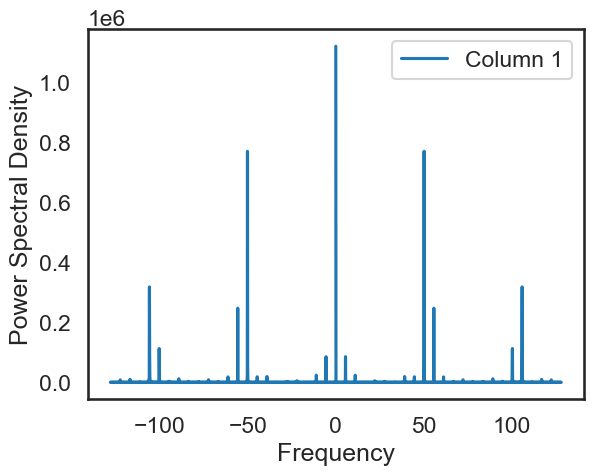

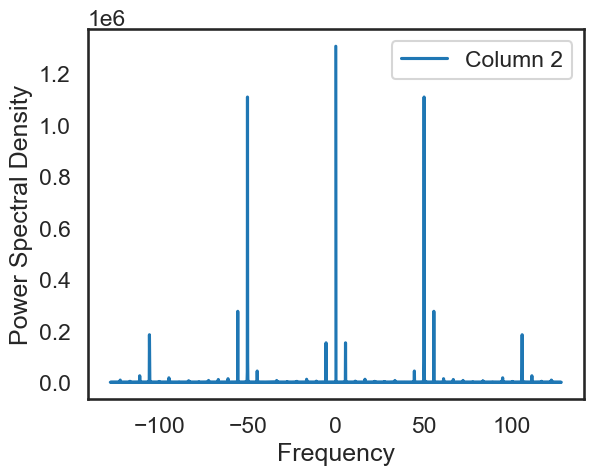

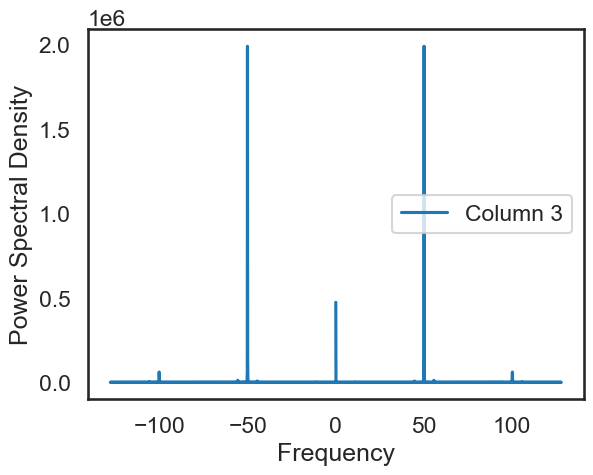

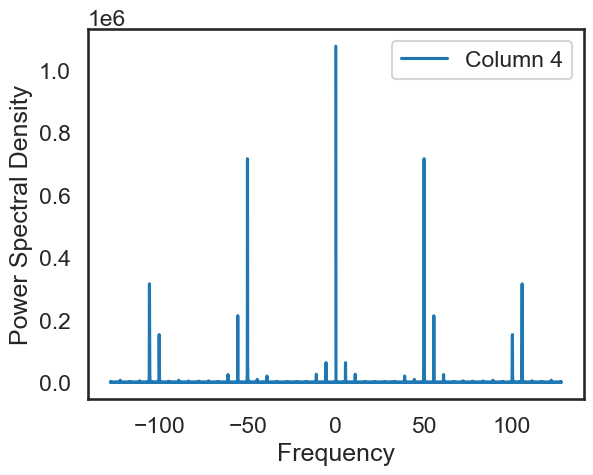

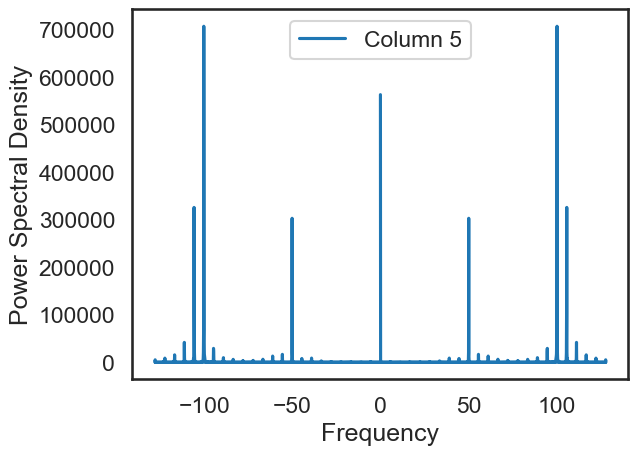

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


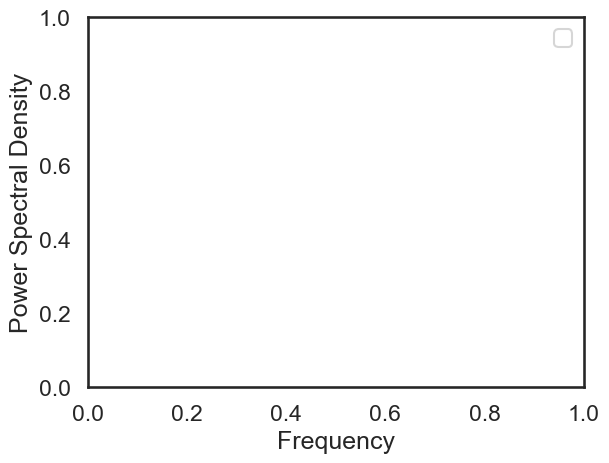

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('C:\\Users\\matil\\Desktop\\FYP\\code_env\\eeg-notebooks\\FYP\\data\\data_muse__raw.csv')

# Extract the time values (first column) and data (other columns)
time = df.iloc[:, 0].values
data = df.iloc[:, 1:].values

# Compute the PSD for each column of the data
fs = 1 / (time[1] - time[0])  # Sampling frequency
n = len(time)  # Number of samples
frequencies = np.fft.fftfreq(n, 1 / fs)
psd = np.zeros((len(frequencies), data.shape[1]))

for i in range(data.shape[1]):
    fft = np.fft.fft(data[:, i])
    psd[:, i] = np.abs(fft) ** 2 / (n * fs)

# Plot the PSD for each column of the data
for i in range(data.shape[1]):
    plt.plot(frequencies, psd[:, i], label=f"Column {i+1}")
    plt.xlabel('Frequency')
    plt.ylabel('Power Spectral Density')
    plt.legend()
    plt.show()

plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.show()


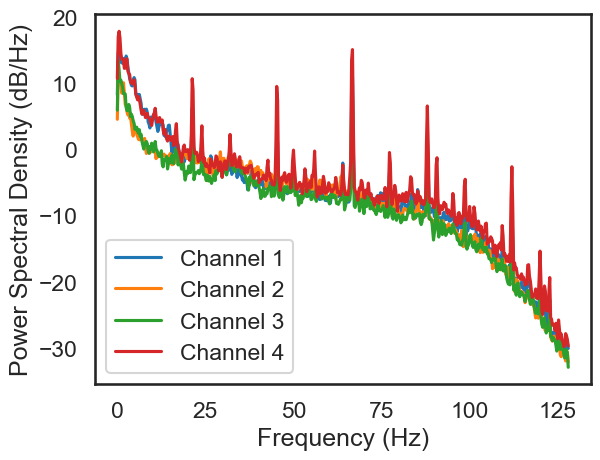

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

# Load CSV file into a pandas DataFrame
df = pd.read_csv('C:\\Users\\matil\\Desktop\\FYP\\code_env\\eeg-notebooks\\FYP\\data\\AudioVisual\\2_recording.csv')

# Extract time and data columns
time = df.iloc[:, 0].values
data = df.iloc[:, 1:5].values.T

# Compute power spectral density with Welch method
f, psds = signal.welch(data, 1 / (time[1] - time[0]), nperseg=1024)

# Plot the PSDs for each channel
for i in range(data.shape[0]):
    plt.plot(f, 10 * np.log10(psds[i]), label=f"Channel {i+1}")

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB/Hz)')
plt.legend()
plt.show()


In [45]:
print(f)
f1 = []
for i in f:
    if i < 40:
        f1.append(i)
print(len(f))
print(len(f1))
print( range(data.shape[0]))

[  0.     0.25   0.5    0.75   1.     1.25   1.5    1.75   2.     2.25
   2.5    2.75   3.     3.25   3.5    3.75   4.     4.25   4.5    4.75
   5.     5.25   5.5    5.75   6.     6.25   6.5    6.75   7.     7.25
   7.5    7.75   8.     8.25   8.5    8.75   9.     9.25   9.5    9.75
  10.    10.25  10.5   10.75  11.    11.25  11.5   11.75  12.    12.25
  12.5   12.75  13.    13.25  13.5   13.75  14.    14.25  14.5   14.75
  15.    15.25  15.5   15.75  16.    16.25  16.5   16.75  17.    17.25
  17.5   17.75  18.    18.25  18.5   18.75  19.    19.25  19.5   19.75
  20.    20.25  20.5   20.75  21.    21.25  21.5   21.75  22.    22.25
  22.5   22.75  23.    23.25  23.5   23.75  24.    24.25  24.5   24.75
  25.    25.25  25.5   25.75  26.    26.25  26.5   26.75  27.    27.25
  27.5   27.75  28.    28.25  28.5   28.75  29.    29.25  29.5   29.75
  30.    30.25  30.5   30.75  31.    31.25  31.5   31.75  32.    32.25
  32.5   32.75  33.    33.25  33.5   33.75  34.    34.25  34.5   34.75
  35. 

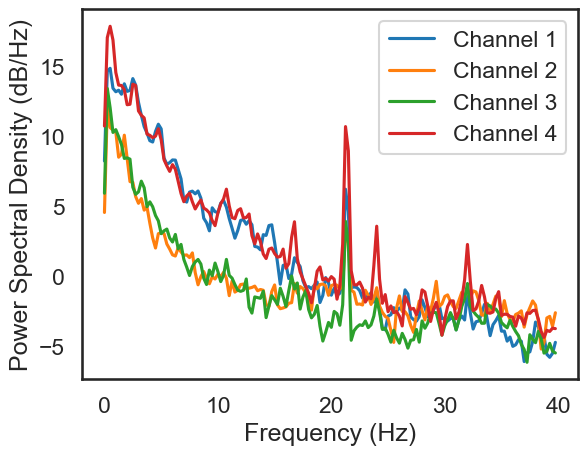

In [46]:
for i in range(data.shape[0]):
        psd_new = (10 * np.log10(psds[i]))[0:160]
        plt.plot(f1, psd_new, label=f"Channel {i+1}")

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB/Hz)')
plt.legend()
plt.show()

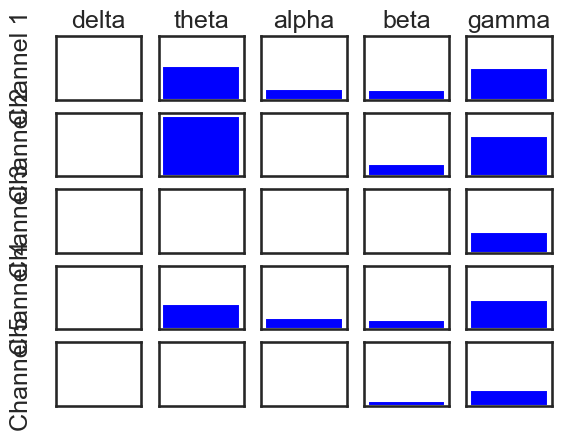

<Figure size 2000x2000 with 0 Axes>

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

# Load CSV file into a pandas DataFrame
df = pd.read_csv('C:\\Users\\matil\\Desktop\\FYP\\code_env\\eeg-notebooks\\FYP\\data\\data_muse__raw.csv')

# Extract time and data columns
time = df.iloc[:, 0].values
data = df.iloc[:, 1:].values.T

# Compute power spectral density with Welch method
f, psds = signal.welch(data, 1 / (time[1] - time[0]), nperseg=1024)

# Define frequency bands
bands = {'delta': (0.5, 4),
         'theta': (4, 8),
         'alpha': (8, 13),
         'beta': (13, 30),
         'gamma': (30, 50)}

# Compute power in each frequency band for each channel
power = {}
for band, (fmin, fmax) in bands.items():
    idx = np.logical_and(f >= fmin, f < fmax)
    for i in range(data.shape[0]):
        channel = f'Channel {i+1}'
        if channel not in power:
            power[channel] = {}
        power[channel][band] = np.trapz(psds[i][idx], f[idx])

# Plot the power in each band for each channel
fig, axs = plt.subplots(nrows=len(power), ncols=len(bands), sharex=True, sharey=True)
for i, (channel, band_power) in enumerate(power.items()):
    for j, (band, value) in enumerate(band_power.items()):
        axs[i, j].bar(0, value, color='blue')
        axs[i, j].set_xticklabels('')
        axs[i, j].set_yticklabels('')
        if i == 0:
            axs[i, j].set_title(band)
        if j == 0:
            axs[i, j].set_ylabel(channel)
plt.figure(figsize=(20,20))
plt.show()


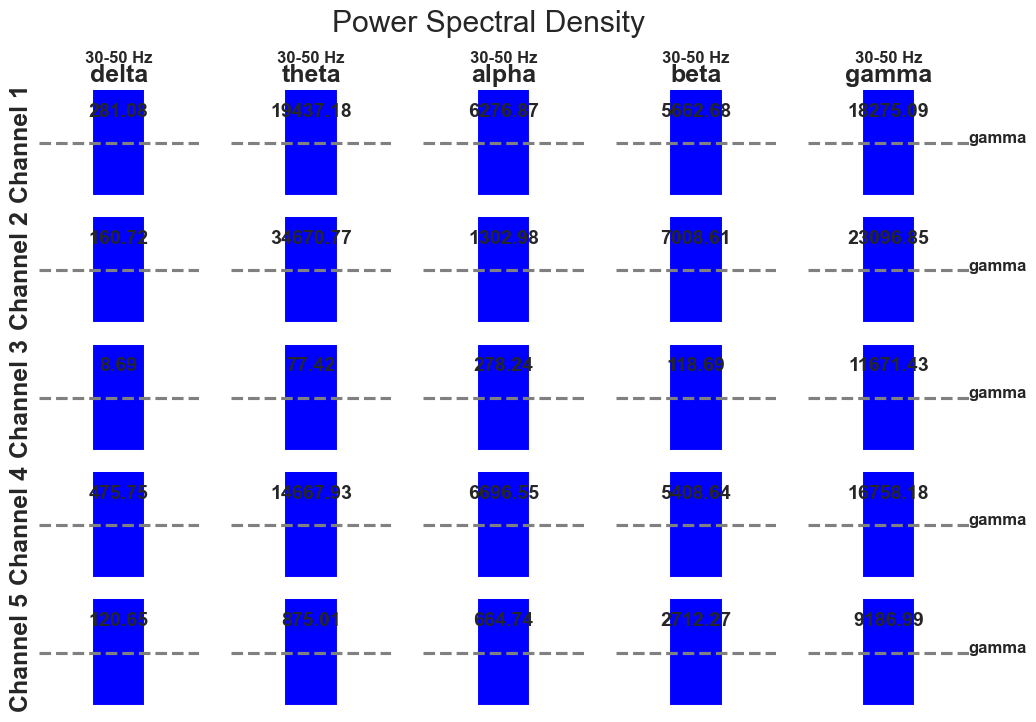

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

# Load CSV file into a pandas DataFrame
df = pd.read_csv('C:\\Users\\matil\\Desktop\\FYP\\code_env\\eeg-notebooks\\FYP\\data\\data_muse__raw.csv')

# Extract time and data columns
time = df.iloc[:, 0].values
data = df.iloc[:, 1:].values.T

# Compute power spectral density with Welch method
f, psds = signal.welch(data, 1 / (time[1] - time[0]), nperseg=1024)

# Define frequency bands
bands = {'delta': (0.5, 4),
         'theta': (4, 8),
         'alpha': (8, 13),
         'beta': (13, 30),
         'gamma': (30, 50)}

# Compute power in each frequency band for each channel
power = {}
for band, (fmin, fmax) in bands.items():
    idx = np.logical_and(f >= fmin, f < fmax)
    for i in range(data.shape[0]):
        channel = f'Channel {i+1}'
        if channel not in power:
            power[channel] = {}
        power[channel][band] = np.trapz(psds[i][idx], f[idx])

# Plot the power in each band for each channel
fig, axs = plt.subplots(nrows=len(power), ncols=len(bands), sharex=True, sharey=True, figsize=(12, 8))
fig.suptitle('Power Spectral Density')
for i, (channel, band_power) in enumerate(power.items()):
    for j, (band, value) in enumerate(band_power.items()):
        ax = axs[i, j]
        ax.bar(0, value, color='blue', width=0.2)
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0:
            ax.set_title(band, fontweight='bold')
        if j == 0:
            ax.set_ylabel(channel, fontweight='bold')
        ax.set_xlim(-0.3, 0.3)
        ax.set_ylim(0, 0.2)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.axhline(y=0.1, color='grey', linestyle='--')
        ax.text(0, 0.15, f'{value:.2f}', ha='center', fontsize=14, fontweight='bold')
        if j == len(bands) - 1:
            ax.text(0.3, 0.1, band, ha='left', fontsize=12, fontweight='bold')
        if i == 0:
            ax.text(0, 0.25, f'{fmin}-{fmax} Hz', ha='center', fontsize=12, fontweight='bold')
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()


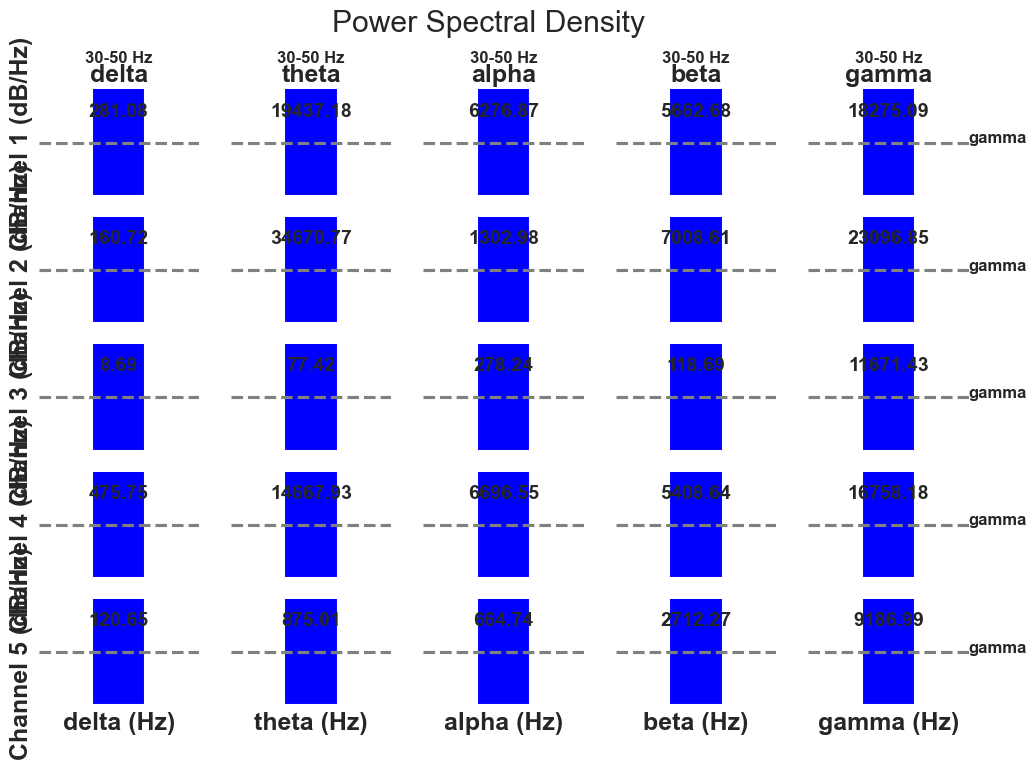

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

# Load CSV file into a pandas DataFrame
df = pd.read_csv('C:\\Users\\matil\\Desktop\\FYP\\code_env\\eeg-notebooks\\FYP\\data\\data_muse__raw.csv')

# Extract time and data columns
time = df.iloc[:, 0].values
data = df.iloc[:, 1:].values.T
#data = data*1e-6
# Compute power spectral density with Welch method
f, psds = signal.welch(data, 1 / (time[1] - time[0]), nperseg=1024)

# Define frequency bands
bands = {'delta': (0.5, 4),
         'theta': (4, 8),
         'alpha': (8, 13),
         'beta': (13, 30),
         'gamma': (30, 50)}

# Compute power in each frequency band for each channel
power = {}
for band, (fmin, fmax) in bands.items():
    idx = np.logical_and(f >= fmin, f < fmax)
    for i in range(data.shape[0]):
        channel = f'Channel {i+1}'
        if channel not in power:
            power[channel] = {}
        power[channel][band] = np.trapz(psds[i][idx], f[idx])

# Plot the power in each band for each channel
fig, axs = plt.subplots(nrows=len(power), ncols=len(bands), sharex=True, sharey=True, figsize=(12, 8))
fig.suptitle('Power Spectral Density')
for i, (channel, band_power) in enumerate(power.items()):
    for j, (band, value) in enumerate(band_power.items()):
        ax = axs[i, j]
        ax.bar(0, value, color='blue', width=0.2)
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0:
            ax.set_title(band, fontweight='bold')
        if j == 0:
            ax.set_ylabel(f'{channel} (dB/Hz)', fontweight='bold')
        if i == len(power) - 1:
            ax.set_xlabel(f'{band} (Hz)', fontweight='bold')
        ax.set_xlim(-0.3, 0.3)
        ax.set_ylim(0, 0.2)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.axhline(y=0.1, color='grey', linestyle='--')
        ax.text(0, 0.15, f'{value:.2f}', ha='center', fontsize=14, fontweight='bold')
        if j == len(bands) - 1:
            ax.text(0.3, 0.1, band, ha='left', fontsize=12, fontweight='bold')
        if i == 0:
            ax.text(0, 0.25, f'{fmin}-{fmax} Hz', ha='center', fontsize=12, fontweight='bold')
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()
